# Imports

In [1]:
import os 
from datetime import datetime

import numpy as np

from classify import temperature
from classify.data.responses import responses_to_traffic_array
from classify.data.traffic import load_traffic
from classify.scenario.bridge import healthy_damage, transverse_crack
from classify.scenario.traffic import normal_traffic
from fem.run.opensees import OSRunner
from model.bridge import Point
from model.bridge.bridge_705 import bridge_705_3d, bridge_705_med_config
from model.response import ResponseType
from plot import plt
from util import resize_units

In [25]:
DATA_PATH = "/Users/jeremy/Desktop/mesh-med-600-mar/"
IMAGE_PATH = "/Users/jeremy/Desktop/saved-images/"
c = bridge_705_med_config(bridge_705_3d)
original_c = c
# Set the directory of where to save/load responses.
c.root_generated_data_dir = os.path.join("/Users/jeremy/Desktop/mesh-med-600-mar", c.root_generated_data_dir)
c.root_generated_data_dir

INFO: Loaded vehicle data from /Users/jeremy/cs/bridge-dss/data/a16-data/a16.csv in 0.18s
WARN: Vehicle PDF sums to 99.5, adjusted to sum to 1


'/Users/jeremy/Desktop/mesh-med-600-mar/generated-data'

# Response type aliases

In [8]:
# Short aliases for response types.
rt_y = ResponseType.YTranslation
rt_s = ResponseType.Strain

# Create functions to resize, and unit strings, for each response type.
resize_y, units_y = resize_units(rt_y.units())
resize_s, _ = resize_units(rt_s.units())

# Temperature data

In [9]:
temps_year = temperature.from_to_mins(
    temperature.load("holly-springs"),
    datetime.fromisoformat(f"2019-01-01T00:00"),
    datetime.fromisoformat(f"2019-12-31T23:59"),
)
temps_year["temp"] = temperature.resize(temps_year["temp"])

Temperature (0.001, 0.999) quantiles = -9.5, 34.5


# Traffic data

In [14]:
total_mins = 4
total_seconds = total_mins * 60
traffic_scenario = normal_traffic(c=c, lam=5, min_d=2)
traffic_sequence, traffic, traffic_array = load_traffic(
    c=c,
    traffic_scenario=traffic_scenario,
    max_time=total_seconds,
)
traffic_array.shape

/Users/jeremy/Desktop/mesh-med-600-mar/generated-data/bridge-705-3d/healthy/traffic/normal-lam-5-600-240-0,01.npy


(24001, 2400)

# Collect time series of responses

In [15]:
response_types = [rt_y, rt_s]
sensor_point = Point(x=51.8, y=0, z=-8.4)
# Split the traffic array in half, the crack will happen halfway through.
half_i = int(len(traffic_array) / 2)
traffic_array_0, traffic_array_1 = traffic_array[:half_i], traffic_array[half_i:]
assert len(traffic_array_0) + len(traffic_array_1) == len(traffic_array)

responses = []
for rt in response_types:
    responses_healthy_cracked = []
    for ds, ta in [(healthy_damage, traffic_array_0), (transverse_crack(), traffic_array_1)]:
        print(f"Sections in damage scenario = {len(ds.use(c)[0].bridge.sections)}")
        responses_healthy_cracked.append(responses_to_traffic_array(
            c=c, traffic_array=ta, response_type=rt, damage_scenario=ds, points=[sensor_point],
        ).T[0])  # Responses from a single point.
    responses.append(np.concatenate(responses_healthy_cracked))
responses = np.array(responses)
responses.shape

Sections in damage scenario = 25
(12000, 2400)
(2400, 1)
Sections in damage scenario = 38
(12001, 2400)
(2400, 1)
Sections in damage scenario = 25
(12000, 2400)
(2400, 1)
Sections in damage scenario = 38
(12001, 2400)
(2400, 1)


(2, 24001)

# Time series of cracked responses

INFO: Saving image to /Users/jeremy/Desktop/saved-images/crack-time-series.pdf


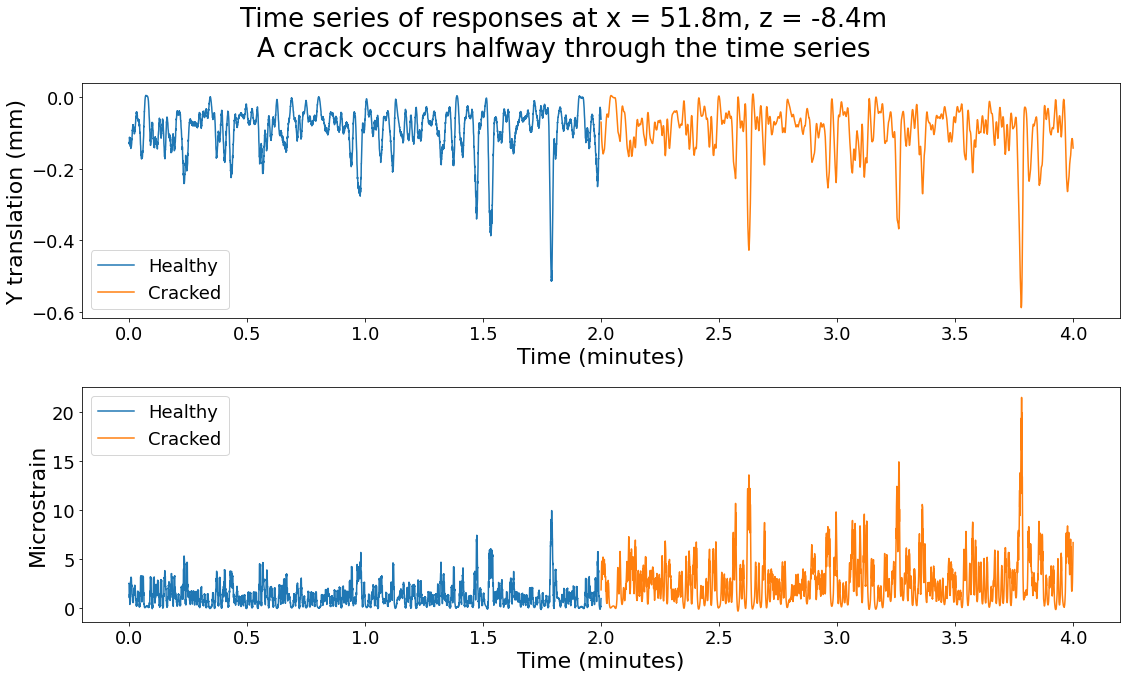

In [28]:
x0 = np.arange(half_i) * c.sensor_hz / 60
x1 = np.arange(half_i, len(responses[0])) * c.sensor_hz / 60
    
plt.landscape()
plt.subplot(2, 1, 1)
plt.plot(x0, responses[0][:half_i] * 1000, label="Healthy")
plt.plot(x1, responses[0][half_i:] * 1000, label="Cracked")
plt.ylabel("Y translation (mm)")
plt.xlabel("Time (minutes)")
plt.legend()
# plt.plot(np.arange(half_i, len(responses[0])), responses[0][half_i:])
plt.subplot(2, 1, 2)
plt.plot(x0, responses[1][:half_i], label="Healthy")
plt.plot(x1, responses[1][half_i:], label="Cracked")
plt.ylabel("Microstrain")
plt.xlabel("Time (minutes)")
plt.legend()
plt.suptitle(f"Time series of responses at x = {sensor_point.x:.1f}m, z = {sensor_point.z:.1f}m\nA crack occurs halfway through the time series")
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
# plt.plot(np.arange(half_i, len(responses[1])), responses[1][half_i:])
plt.savefig(os.path.join(IMAGE_PATH, "crack-time-series.pdf"))

# Collect time series of responses
A number of time series, in each time series the crack happens at a random time.

In [17]:
response_types = [rt_y, rt_s]
sensor_point = Point(x=51.8, y=0, z=-8.4)
total_time_series = 50

crack_indices = []
time_series = []
for _ in range(total_time_series):
    crack_index = np.random.randint(0, len(traffic_array))  # A crack can occur anytime.
    crack_indices.append(crack_index)
    time_series.append([])
    for rt in response_types:
        responses_healthy_cracked = []
        for ds, lo, hi in [(healthy_damage, 0, crack_index), (transverse_crack(), crack_index + 1, len(traffic_array))]:
            if lo == hi:  # Length 0 time series.
                continue
#             print(f"Sections in damage scenario = {len(ds.use(c)[0].bridge.sections)}")
            responses_healthy_cracked.append(responses_to_traffic_array(
                c=c, traffic_array=traffic_array[lo:hi], response_type=rt, damage_scenario=ds, points=[sensor_point],
            ).T[0])  # Responses from a single point.
        time_series[-1].append(np.concatenate(responses_healthy_cracked))
time_series = np.array(time_series)
time_series.shape

(23148, 2400)
(2400, 1)
(852, 2400)
(2400, 1)
(23148, 2400)
(2400, 1)
(852, 2400)
(2400, 1)
(21702, 2400)
(2400, 1)
(2298, 2400)
(2400, 1)
(21702, 2400)
(2400, 1)
(2298, 2400)
(2400, 1)
(2581, 2400)
(2400, 1)
(21419, 2400)
(2400, 1)
(2581, 2400)
(2400, 1)
(21419, 2400)
(2400, 1)
(10797, 2400)
(2400, 1)
(13203, 2400)
(2400, 1)
(10797, 2400)
(2400, 1)
(13203, 2400)
(2400, 1)
(7667, 2400)
(2400, 1)
(16333, 2400)
(2400, 1)
(7667, 2400)
(2400, 1)
(16333, 2400)
(2400, 1)
(116, 2400)
(2400, 1)
(23884, 2400)
(2400, 1)
(116, 2400)
(2400, 1)
(23884, 2400)
(2400, 1)
(20383, 2400)
(2400, 1)
(3617, 2400)
(2400, 1)
(20383, 2400)
(2400, 1)
(3617, 2400)
(2400, 1)
(3561, 2400)
(2400, 1)
(20439, 2400)
(2400, 1)
(3561, 2400)
(2400, 1)
(20439, 2400)
(2400, 1)
(15109, 2400)
(2400, 1)
(8891, 2400)
(2400, 1)
(15109, 2400)
(2400, 1)
(8891, 2400)
(2400, 1)
(23860, 2400)
(2400, 1)
(140, 2400)
(2400, 1)
(23860, 2400)
(2400, 1)
(140, 2400)
(2400, 1)
(13020, 2400)
(2400, 1)
(10980, 2400)
(2400, 1)
(13020, 2400)
(2

(50, 2, 24000)

In [18]:
plt.landscape()
for i in range(len(time_series)):
    plt.subplot(len(time_series), 1, i + 1)
    plt.title(f"Crack at {total_mins * crack_indices[i] / len(traffic_array):.2f}")
    plt.plot(np.arange(len(time_series[i][1])) * c.sensor_hz / 60, time_series[i][1])
plt.tight_layout()
plt.savefig("/Users/jeremy/Desktop/hi.pdf")
# plt.show()
plt.close()

/Users/jeremy/.local/share/virtualenvs/bridge-dss-jupQo_Ui/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  


INFO: Saving image to /Users/jeremy/Desktop/hi.pdf


# Setup experiments

In [20]:
expts = []  # A list of <time series index, experiment time index, crack index>
# For each time series..
for t_i in range(len(time_series)):
    # ..after each minute of responses (except the first).
    for m_i in range(3, total_mins + 1):
        expts.append((
            t_i,
            int(m_i * (len(traffic_array) / total_mins)),
            crack_indices[t_i],
        ))

# Collect features.

In [21]:
from scipy import stats

# X is of shape 'samples x features'.
# Y is of length 'samples' and contains the labels.
X, Y = [], []
rt = 1
for t_i, e_i, c_i in expts:
    delta = int(len(traffic_array) / total_mins)  # Length of one minute of responses.
    cracked = e_i - (2 * delta) < c_i < e_i - delta
    prev_samples = np.array(time_series[t_i][rt][e_i - (3 * delta):e_i - (2 * delta)])
    samples = np.array(time_series[t_i][rt][e_i - delta:e_i])
    Y.append(cracked)
    ks = stats.ks_2samp(prev_samples, samples)
    X.append((ks.statistic, ks.pvalue))
#     print(prev_samples.shape, samples.shape)
#     min_len = min(len(prev_samples), len(samples))
#     X.append(np.array([prev_samples[:min_len], samples[:min_len]]))
#     print(f"Cracked = {cracked}", e_i, c_i)
#     results.append((stats.ks_2samp(prev_samples, samples), cracked))

# Run experiments

In [22]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
len(X_train), len(X_test)

(660, 440)

In [23]:
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X, Y, cv=5)
scores

from sklearn.metrics import classification_report

classification_report(y_test, clf.train)

AttributeError: 'SVC' object has no attribute 'train'

In [ ]:
ks_cutoff = 0.3
tp, fp, tn, fn = 0, 0, 0, 0
for ks, cracked in results:
    if cracked:
        if ks.statistic > ks_cutoff:
            tp += 1
        else:
            fp += 1
    else:
        if ks.statistic <= ks_cutoff:
            tn += 1
        else:
            fn += 1
for name, count in [("TP", tp), ("FP", fp), ("TN", tn), ("FN", fn)]:
    print(f"{name} = {count / len(results):.2f}")
print(f"T / T + F = {(tp + tn) / len(results):.2f}")
# results